# Gemini Workshop: The Hands-On Lab Session

During This Session:

- You will learn a little bit about Jupyter, a web-based programming environment.
- You will learn a little Python, a popular programming language.
- You will explore an RF signal dataset.
- You will learn about hamming fingerprints.
- You will use Gemini to search a RF signal dataset where each signal is represented by a hamming fingerprint.
- You will use search results to classify unknown RF signals using a technique called KNN

To help solidify your understanding, you will be presented with exercises along the way.  OK, Let's Get Started !
***

# What Is Jupyter?

* Jupyter is the web-based programming environment that you are in right now.  
* A Jupyter "notebook" is composed of a bunch of "cells" stacked on top of each other.  
* Some cells are for documentation (like this one.) 
* Some cells are for Python code.
* Some cells show the output of code cells.  
* This will become more obvious as we proceed through this notebook.
***

# Exercise 1

Now for your first exercise:  
* The cell right below this one contains some code.  Click once in the code cell.  This will make the cell active ( notice the blue outline. )  
* Locate the "play" button in the toolbar at the top of the notebook.  You should see an image appear right below the code.
***

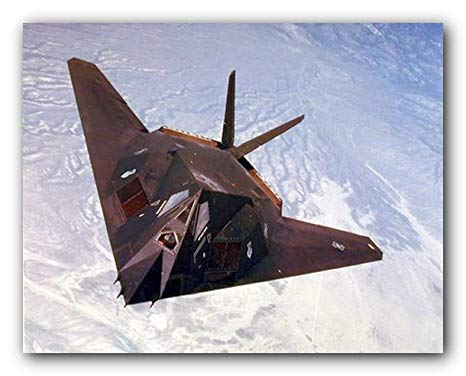

In [1]:
from IPython.display import Image
Image("asurprise.jpg") 

# What Is Python?

Congratulations.  If you got the image to appear, you successfully ran python code in this Jupyter notebook!  Python is a popular programming language and we will use it throughout this session.

***

# Exercise 2

* The cell right below this one contains some code.  Run it and you will notice it will print a random number right below it.
* Trying running it several times.  Notice it will display a different random number each time.  ( Note that you will need to click on the code cell to reselect it.  That's because Jupyter automatically hops to the next cell after execution. )

***

In [2]:
import random
print( random.random() )

0.9184948090852045


***
# Radio Frequency Signal Classification

Alright, let's start to dig into the application we are showcasing in this session - RF Signal Classification.  This is an important application in government and aerospace for signal monitoring and spectrum management.

We will be using Gemini to help us classify unknown radio frequency (RF) signals.
***

# Exercise 3

* The cell right below this one contains some code to load an RF signal database.  Run it and you should notice a message indicating success right below the code cell.

***

In [3]:
import rf_signals
import importlib
importlib.reload(rf_signals)
rf_signals.load()

The known RF signal database loaded successfully.  There are 10000 signals, of bitsize=256.


***

# Exercise 4

* The next cell's code will choose at random some of the signals and display them.  Feel free to run it several times.
* The database has several types of signals with names like '64APSK', 'AM-SSB-WC', '32PSK', etc., and there are many examples of each in the database.  

***

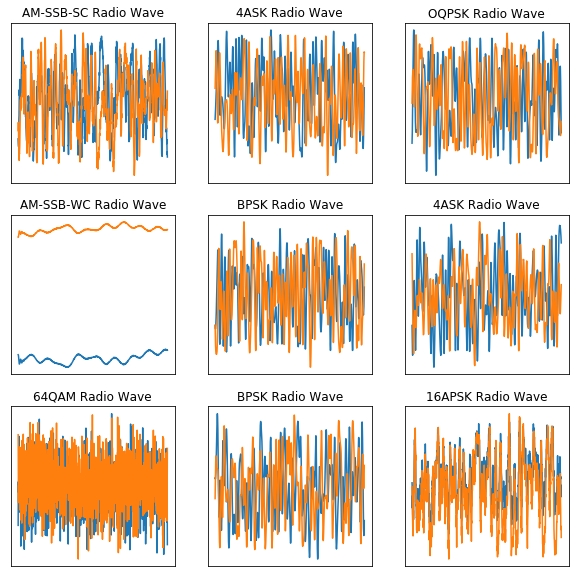

In [4]:
rf_signals.randisplay()

***
# Exercise 5

* Now let's load a different dataset of signals.  In this database, the signals haven't yet been classified.  
* Go ahead and run the next code cell to load the database of unknown signals.

***

In [5]:
import unknown_signals
unknown_signals.load()

The unknown RF signals database loaded successfully.  There 5000 signals of bitsize=256.


***

# Exercise 6

* The next cell's code will choose at random some of the signals and display them.  Feel free to run it several times.
* Remember, the signals in this database have not been classified yet!  That's why you see a question mark in the subplot titles.

***

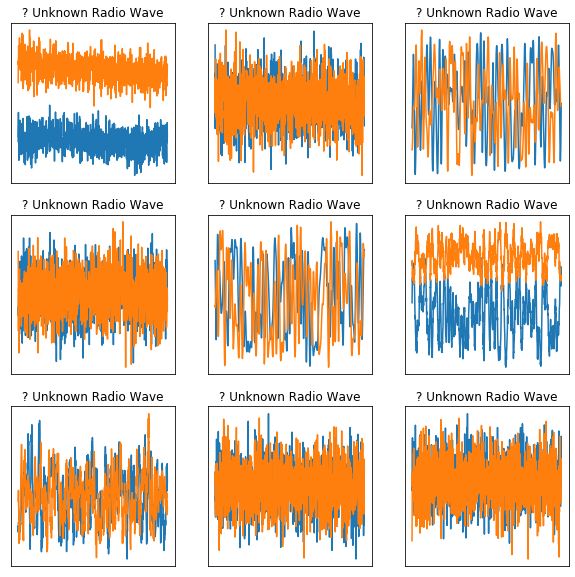

In [6]:
unknown_signals.randisplay()

***

# Exercise 7

Now you will use Gemini similarity search in order to help classify the unknown signals.  

First, let's initialize the GNL library.  Go ahead and run the next code cell.

***

In [7]:
import gnl_bindings
import gnl_bindings_utils as gbu

def setUpGNL():
    s = gnl_bindings.gdl_init()
    if s: raise Exception('gnl_bindings.gdl_init failed with {}'.format(s))

    s, gdl_ctx = gnl_bindings.gdl_context_find_and_alloc(apuc_count=4, mem_size=0x10000000)  # need to change num of apuc
    if s: raise Exception('gnl_bindings.gdl_context_find_and_alloc failed with {}'.format(s))

    s = gnl_bindings.init()
    if s: raise Exception('gnl_bindings.init failed with {}'.format(s))

    s, base_ctx = gnl_bindings.create_base_context(gdl_ctx)
    if s: raise Exception('gnl_bindings.create_base_context failed with {}'.format(s))
    
    s, gnl_ctxs = gnl_bindings.create_contexts(base_ctx, [4])  # need to change num of apuc
    if s: raise Exception('gnl_bindings.create_contexts failed with {}'.format(s))
    
    ctx = gnl_ctxs[0]
    s = gnl_bindings.pm_ctl(ctx, True)
    if s: raise Exception('gnl_bindings.pm_ctl failed with {}'.format(s))
    return gdl_ctx, base_ctx, ctx

print("Setting up GNL...")
gdl_ctx, base_ctx, ctx = setUpGNL()
print("Done.")

Setting up GNL...
Done.


***

# Exercise 8

Now, let's perform the hamming search.  Go ahead and run the next code cell.

***

In [8]:
import numpy as np
import time, datetime

# Get the known database fingerprints and transpose for the GNL
np_records = np.copy( rf_signals.get_fingerprints() )
np_records = np.transpose(np_records, (1, 0))

# Use the unknown database fingerprints as the query
np_queries = unknown_signals.get_fingerprints()

# Define the number of neighbors you want
k = 5

# Define the shape of the output arrays according to the num of queries and k
out_shape = (np_queries.shape[0], k)
#print("outshape", out_shape)

# Define the output arrays
np_out_vals = np.empty(out_shape, np.uint16)
np_out_indices = np.empty(out_shape, np.uint32)

#
# Convert the numpy arrays to gnl
#

s, gnl_out_vals = gbu.create_gnl_array_from_numpy(base_ctx, ctx, np_out_vals, gbu.gnl_type.GNL_U16, False)
if s: raise Exception('gbu failed with {}'.format(s))
        
s, gnl_out_indices = gbu.create_gnl_array_from_numpy(base_ctx, ctx, np_out_indices, gbu.gnl_type.GNL_U32, False)
if s: raise Exception('gbu failed with {}'.format(s))

s, gnl_data = gbu.create_gnl_array_from_numpy(base_ctx, ctx, np_records, gbu.gnl_type.GNL_U16)
if s: raise Exception('gbu failed with {}'.format(s))

s, gnl_queries = gbu.create_gnl_array_from_numpy(base_ctx, ctx, np_queries, gbu.gnl_type.GNL_U16)
if s: raise Exception('gbu failed with {}'.format(s))

# Perform hamming search
start = time.time()
print(datetime.datetime.now(),"Starting hamming search in Gemini.")
s = gnl_bindings.knn_hamming(ctx, gnl_out_vals, gnl_out_indices, gnl_queries, gnl_data, k)
if s: raise Exception('gbu failed with {}'.format(s))
end = time.time()
GNLSearchTime = end - start
print(datetime.datetime.now(),"Search duration was", GNLSearchTime, "seconds.")

# Convert the output from gnl arrays to numpy
s, np_out_vals = gbu.create_numpy_array_from_gnl(ctx, gnl_out_vals)
if s: raise Exception('gbu failed with {}'.format(s))
    
s, np_out_indices = gbu.create_numpy_array_from_gnl(ctx, gnl_out_indices)
if s: raise Exception('gbu failed with {}'.format(s))
        
# Clean up (delete gnl arrays)
gnl_bindings.destroy_array(gnl_out_vals)
gnl_bindings.destroy_array(gnl_out_indices)
gnl_bindings.destroy_array(gnl_queries)
gnl_bindings.destroy_array(gnl_data)

print("The shape of the search results is ", np_out_indices.shape)

2020-01-08 06:03:48.807509 Starting hamming search in Gemini.
2020-01-08 06:04:02.168536 Search duration was 13.361002206802368 seconds.
The shape of the search results is  (5000, 5)


***

# Exercise 9

Now, before we use the results for signal classification.  Let's go ahead and release the GNL library.

Go ahead and run the next cell.

***

In [9]:
def tearDownGNL(gdl_ctx, base_ctx, ctx):
    s = gnl_bindings.pm_ctl(ctx, False)
    if s: raise Exception('gnl_bindings.pm_ctl failed with {}'.format(s))
    s = gnl_bindings.destroy_contexts(base_ctx)
    if s: raise Exception('gnl_bindings.destroy_contexts failed with {}'.format(s))
    s = gnl_bindings.destroy_base_context(base_ctx)
    if s: raise Exception('gnl_bindings.destroy_base_context failed with {}'.format(s))
    gnl_bindings.exit(False)
    s = gnl_bindings.gdl_context_free(gdl_ctx)
    if s: raise Exception('gnl_bindings.gdl_context_free failed with {}'.format(s))
    s = gnl_bindings.gdl_exit()
    if s: raise Exception('gnl_bindings.gdl_exit failed with {}'.format(s))
        
tearDownGNL( gdl_ctx, base_ctx, ctx )

***

# Exercise 10

Now, lets use those similarity search predictions.  Run the code below.  

It will randomly choose three of the unknown signals (top row).  Directly below each unknown are the top 5 matches from similarity search.  

We can now use a majority vote of the top-K matches (K=5 in this case) in order to classify the unknown signal.  This is called KNN classification.

***

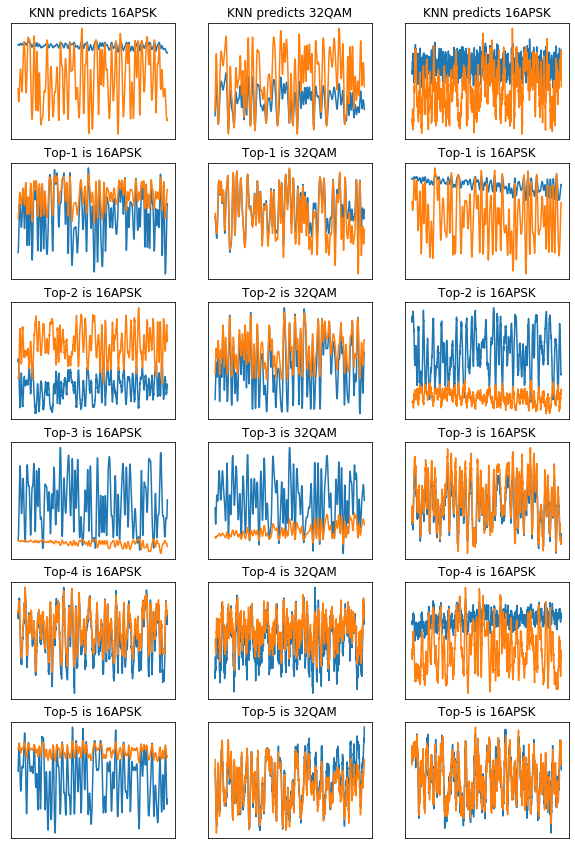

In [10]:
import knn
predictions = knn.classify( rf_signals, unknown_signals, np_out_indices )
knn.randisplay( predictions, rf_signals, unknown_signals )